In [22]:
import sys
import numpy as np
import cv2

import plotly.graph_objects as go
import os
import scipy.misc
from scipy.optimize import least_squares
import math
from copy import deepcopy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sfm_utils import *

from triangulation import *

In [23]:
image_data_dir = 'data/statue/'
unit_test_camera_matrix = np.load('data/unit_test_camera_matrix.npy')
unit_test_image_matches = np.load('data/unit_test_image_matches.npy')
image_paths = [os.path.join(image_data_dir, 'images', x) for x in sorted(os.listdir('data/statue/images')) if '.jpg' in x]

In [24]:

focal_length = 719.5459
matches_subset = np.load(os.path.join(image_data_dir,'matches_subset.npy'), allow_pickle=True,encoding='latin1')[0,:]
dense_matches = np.load(os.path.join(image_data_dir, 'dense_matches.npy'),allow_pickle=True,encoding='latin1')
fundamental_matrices = np.load(os.path.join(image_data_dir,'fundamental_matrices.npy'),allow_pickle=True,encoding='latin1')[0,:]


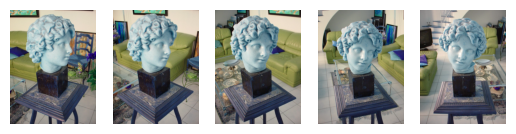

In [25]:
for i in range(5):
  img = cv2.imread(image_paths[i])
  plt.subplot(1,5,i+1)
  plt.imshow(img)
  plt.axis('off')

In [26]:
print(len(fundamental_matrices))
print(len(dense_matches))
print(len(matches_subset))

4
4
4


In [27]:
print(dense_matches[0].shape)
print(matches_subset[0].shape)

(4, 29189)
(4, 50)


In [28]:

im0 = cv2.imread(image_paths[0])
im_height, im_width, _ = im0.shape

In [29]:
print(len(image_paths))

5


In [30]:
class Frame:
    def __init__(self, matches, focal_length, F, im_width, im_height):
        self.focal_length = focal_length
        self.im_height = im_height
        self.im_width = im_width
        self.matches = matches

        self.N = matches.shape[0]
        self.match_idx = np.array([np.arange(self.N), np.arange(self.N, 2 * self.N)])
        self.match_points = np.vstack((matches[:,:2], matches[:,2:]))

        self.K = np.eye(3)
        self.K[0,0] = self.K[1,1] = focal_length
        self.E = self.K.T.dot(F).dot(self.K)
        self.T = estimate_RT_from_E(self.E, matches.reshape((-1,2,2)), self.K)

        self.motion = np.zeros((2,3,4))
        self.motion[0,:,:-1] = np.eye(3)
        self.motion[1,:,:] = self.T
        self.structure = triangulate(self)

In [31]:
frames = [0] * (len(image_paths) - 1)
for i in range(len(image_paths)-1):
        frames[i] = Frame(matches_subset[i].T, focal_length,
                fundamental_matrices[i], im_width, im_height)
        bundle_adjustment(frames[i])

/content/triangulation.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  P_homo = np.array([P[0], P[1], P[2], 1.0])


In [32]:
merged_frame = deepcopy(frames[0])
for i in range(1,len(frames)):
        merged_frame = merge_two_frames(merged_frame, frames[i], i+1)
        merged_frame.structure = triangulate(merged_frame)
        bundle_adjustment(merged_frame)
        remove_outliers(merged_frame, 10)
        bundle_adjustment(merged_frame)

In [36]:
structure=merged_frame.structure

In [37]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=structure[:,0], y=structure[:,1], z=structure[:,2],
            mode='markers',
            marker=dict(size=1, color=(0,0,255))
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
)
fig.show()

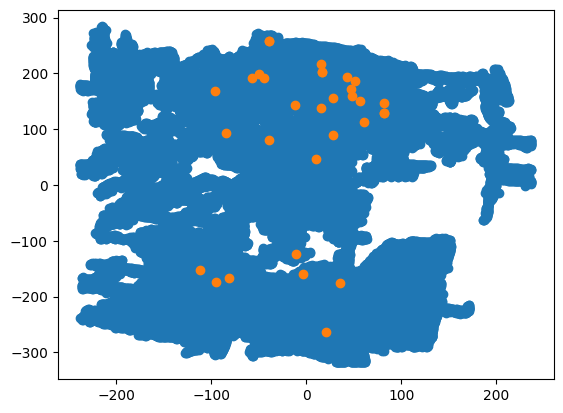

In [42]:

plt.scatter(dense_matches[i][0,:],dense_matches[i][1,:])
plt.scatter(matches_subset[i][0,:],matches_subset[i][1,:])

In [43]:
# Construct the dense matching
camera_matrices = np.zeros((2,3,4))
dense_structure = np.zeros((0,3))
for i in range(len(frames)-1):
        matches = dense_matches[i]
        camera_matrices[0,:,:] = merged_frame.K.dot(merged_frame.motion[i,:,:])
        camera_matrices[1,:,:] = merged_frame.K.dot(merged_frame.motion[i+1,:,:])

        points_3d = np.zeros((matches.shape[1], 3))
        use_point = np.array([True]*matches.shape[1])
        for j in range(matches.shape[1]):
            points_3d[j,:] = nonlinear_estimate_3d_point(matches[:,j].reshape((2,2)), camera_matrices)
        dense_structure = np.vstack((dense_structure, points_3d[use_point,:]))




In [44]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=dense_structure[:,0], y=dense_structure[:,1], z=dense_structure[:,2],
            mode='markers',
            marker=dict(size=1, color=(0,0,255))
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [46]:
!pip install open3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 104.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 105.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.9/214.9 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 95.8 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.5
    Uninstalling widgetsnbextension-3.6.5:
      Successfully uninstalled widgetsnbextension-3.6.5
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 2.3.7
    Uninstalling Werkzeug-2.3.7:
      Successfully uninstalled Werkzeug-2

In [47]:
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(dense_structure)
o3d.io.write_point_cloud("sync.ply", pcd)

True